## CSYE 7245 Final Project - DGA Detection with Machine Learning and Deep Learning


### Course Information
* **School**: College of Engineering, Northeastern University
* **Course Name**: Big-Data Systems and Intelligence Analytics
* **Professor**: Nik Brown

### Group Members
*(Alphabetically ordered)*
- Haimin Zhang
- Lixi Zhou
- Shiqi Dai


### What is DGA?

DGA, Domain Generation Algorithms, are used in various families of malware. It generates plenty of malicious domain names that can be used as rendezvous points with their command and control (C2) servers. 

### How to cope with DGA

#### Traditional Ways:
- Blacklist
- Reverse engineering
- Comapring statistical properties in similar domain groups

#### Disadvantage:
It lacks the capability to be used for real-time detection and protection

### Research Idea
DGAs can constantly generate large amounts of domains to evade blacklist detection. It is hard to block the connection between hackers and zombie computers in real-time with traditional ways. In order to solve this problem, we decided to use machine learning algorithms to detect DGAs and compare the performance of these algorithms.

### Algorithms
- Random Forest
- Gradient Boosting Machine
- Naive Bayes Classifer
- Convolutional Neural Network
- Long Short-Term Memory Neural Network

### Project Goal
- Reaching a better performance with an accuracy higher than 98%.
- Model Selection:
    Among all the models experimented, choose a solution which can be a single machine learning algorithm model or an ensemble model. And recommend this solution to real word practice.


## Data Sources
#### Benign Domains:

- [Alexa Top 1 Million Sites](https://www.kaggle.com/cheedcheed/top1m): The Alexa Top Sites web service provides access to lists of websites ordered by Alexa Traffic Rank. ([License](<http://osint.bambenekconsulting.com/license.txt>))**(Size: 2,476,328)**
(https://www.kaggle.com/cheedcheed/top1m)

#### Malicious DGA Domains:

- [Bambenek Consulting provided malicious algorithmically-generated domains](http://osint.bambenekconsulting.com/feeds/dga-feed.txt) ([License](<http://osint.bambenekconsulting.com/license.txt>)) **(Size: 872,763)**
- [360 Lab DGA Domains](https://data.netlab.360.com/feeds/dga/dga.txt): A collection of domains generated by DGA and it is maintained by 360--a Chinese security vendor. This dataset keeps updated every day. ([License](<http://osint.bambenekconsulting.com/license.txt>))**(Size: 1,169,720)**

---

**Note: The data folder is not  included in the zip file, because it is about 600MB. We upload our dataset to Google Drive, You can download it from the link below:**

**(Please access Google Drive with Northeastern Account)**:

https://drive.google.com/drive/folders/1m-p5_liIoSeX2pJhfMSCDDtTm3XyTCrq?usp=sharing

---

## Initialization

In [164]:
import numpy as np
import pandas as pd
import re
from publicsuffixlist import PublicSuffixList
import gc
import math
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D, Input, Flatten
from keras import regularizers


RANDOM_SEED = 1

%matplotlib inline

E:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Original Data

**If you want to run this notebook faster, you can start from `INPUT[72]`, load the data with features from disk(which is saved from previous features engineering)**

### Imprt Alexa Top 1 Million Sites

In [6]:
# Load Bengin Domains data from .csv file and set the labels
benign_domain = pd.read_csv('data/top-1m-domain.csv', header=None, names=['Domain'])
benign_domain.head()
benign_domain['DGA_Family'] = 'none'
benign_domain['Type'] = 'Normal'
benign_domain =benign_domain[['DGA_Family','Domain','Type']]
benign_domain.describe()

,DGA_Family,Domain,Type
count,1000000,1000000,1000000
unique,1,1000000,1
top,none,comfenalcoantioquia.com,Normal
freq,1000000,1,1000000


### Import 360 DGA Data

In [7]:
# Load DGA Domains data from .txt file and set the labels
dga_domain = pd.read_table('data/360_dga.txt',names=['DGA_Family','Domain','Start_time','End_time'])
dga_domain = dga_domain.iloc[:, 0:2]
dga_domain['Type']='DGA'
dga_domain.to_csv('data/360_dga_domain.csv', index = False)
dga_domain.describe()

,DGA_Family,Domain,Type
count,1169720,1169720,1169720
unique,42,1147770,1
top,banjori,ooynanarianaqh.com,DGA
freq,452428,7,1169720


### Import Bambenek Consulting provided malicious algorithmically-generated domains

In [8]:
# Load DGA Domains from .txt file and set labels
bambenek_dga_domain = pd.read_csv('data/dga-feed.txt',header=None,sep=',',names=['Domain','DGA_Family','time','description_url'])
bambenek_dga_domain = bambenek_dga_domain[['DGA_Family','Domain']]
bambenek_dga_domain['Type']='DGA'
dga_familiy_list = list()
bambenek_dga_domain['DGA_Family']=bambenek_dga_domain['DGA_Family'].apply(lambda x: x.split(' ')[3])
bambenek_dga_domain.to_csv('data/bambenek_dga_domain.csv', index = False)
bambenek_dga_domain.describe()

,DGA_Family,Domain,Type
count,872763,872763,872763
unique,52,855571,1
top,banjori,reropmunqvkext.me,DGA
freq,439223,62,872763


### Combine Alexa Top, Bambenek DGA and 360 Lab DGA

In [9]:
# Combine the Benign Domains and DGA Domains dataset
dga_domain = pd.concat([dga_domain,bambenek_dga_domain],axis=0)
dga_domain = dga_domain.drop_duplicates()
df_domain = pd.concat([dga_domain,benign_domain])
df_domain.describe()

,DGA_Family,Domain,Type
count,2475328,2475328,2475328
unique,70,2461354,2
top,none,phylzkfhrwlzbmltudai.org,DGA
freq,1000000,3,1475328


### Shuffle all data and save data to csv file

In [10]:
# Shuffle the dataset
df_domain_shuffle = df_domain.sample(frac = 1, random_state=RANDOM_SEED)
df_domain_shuffle.to_csv('data/mixed_domain.csv', index = False)

In [39]:
df_domain_shuffle.head()

,DGA_Family,Domain,Type
810644,none,prata.pt,Normal
457127,banjori,bxjofordlinnetavox.com,DGA
279939,emotet,tbaxcrnxirtmuusq.eu,DGA
675998,rovnix,fbo6fssycmvf16nb47.net,DGA
438398,none,giftcardsinfo1.icu,Normal


## Features Engineering

At the end of this part, the dataset would **has the following attributes**

- **DGA_Family**: represents the family of DGA

- **Domain**

- **Type**: represents that a domain is a DGA domain or Normal DGA **(This is the target variable which need to be predicted)**

| Type | Value|
| ----- | ----|
| Normal | 0 |
| DGA | 1 |

- **DNL** (Domain Name Length): represents the length of a domain

- **NoS** (Number of Subdomains): represents the number of subdomains ***(Ignore valid public suffixes)***

- **SLM** (Subdomain Length Mean): represents the mean of subdomain length ***(Ignore valid public suffixes)***

- **HwP** (Has www Prefix):

| HwP | Value|
| ----- | ----|
| Has www | 1 |
| Does not have | 0 |

- **HVTLD** (Has a Valid Top Level Domain): 

| HVLTD | Value|
| ----- | ----|
| Has | 1 |
| Does not have | 0 |

- **CSCS** (Contains Single-Character Subdomain): ***(Ignore valid public suffixes)***

| CSCS | Value|
| ----- | ----|
| Has | 1 |
| Does not have | 0 |

- **CTS** (Contains Top Level Domain as Subdomain): ***(Ignore valid public suffixes)***

| CSCS | Value|
| ----- | ----|
| Has | 1 |
| Does not have | 0 |

- **UR** (Underscore Ratio): Reprents the ratio of underscore ***(Ignore valid public suffixes)***

- **CIPA** (Contains IP Address): ***(Ignore valid public suffixes)***

| CIPA | Value|
| ----- | ----|
| Contains IP Address | 1 |
| Does not contain | 0 |

- **contains_digit** (Contains digit): ***(Ignore valid public suffixes)***

| contains_digit | Value|
| ----- | ----|
| Contains digit | 1 |
| Does not contain digit | 0 |

- **vowel_ration** (The ratio of vowel): ***(Ignore valid public suffixes)***

- **digit_ratio** (The ratio of digit): ***(Ignore valid public suffixes)***

- **RRC** (The ratio of repeated characters in a subdomain): ***(Ignore valid public suffixes)***

- **RCC** (The ratio of consecutive consonants): ***(Ignore valid public suffixes)***

- **RCD** (The ratio of consecutive digits): ***(Ignore valid public suffixes)***

- **Entropy** (The entropy of subdomain): ***(Ignore valid public suffixes)***

In [87]:
# Generate a copy of original dataset
domain_withFeatures = df_domain_shuffle.copy()
domain_withFeatures.head()

,DGA_Family,Domain,Type
810644,none,prata.pt,Normal
457127,banjori,bxjofordlinnetavox.com,DGA
279939,emotet,tbaxcrnxirtmuusq.eu,DGA
675998,rovnix,fbo6fssycmvf16nb47.net,DGA
438398,none,giftcardsinfo1.icu,Normal


## Define the function to generate features

In [88]:
# Load Valid Top Level Domains data
import sys

topLevelDomain = []
with open('data/tlds-alpha-by-domain.txt', 'r') as content:
    for line in content:
        topLevelDomain.append((line.strip('\n')))
        
print(topLevelDomain)

['AAA', 'AARP', 'ABARTH', 'ABB', 'ABBOTT', 'ABBVIE', 'ABC', 'ABLE', 'ABOGADO', 'ABUDHABI', 'AC', 'ACADEMY', 'ACCENTURE', 'ACCOUNTANT', 'ACCOUNTANTS', 'ACO', 'ACTIVE', 'ACTOR', 'AD', 'ADAC', 'ADS', 'ADULT', 'AE', 'AEG', 'AERO', 'AETNA', 'AF', 'AFAMILYCOMPANY', 'AFL', 'AFRICA', 'AG', 'AGAKHAN', 'AGENCY', 'AI', 'AIG', 'AIGO', 'AIRBUS', 'AIRFORCE', 'AIRTEL', 'AKDN', 'AL', 'ALFAROMEO', 'ALIBABA', 'ALIPAY', 'ALLFINANZ', 'ALLSTATE', 'ALLY', 'ALSACE', 'ALSTOM', 'AM', 'AMERICANEXPRESS', 'AMERICANFAMILY', 'AMEX', 'AMFAM', 'AMICA', 'AMSTERDAM', 'ANALYTICS', 'ANDROID', 'ANQUAN', 'ANZ', 'AO', 'AOL', 'APARTMENTS', 'APP', 'APPLE', 'AQ', 'AQUARELLE', 'AR', 'ARAB', 'ARAMCO', 'ARCHI', 'ARMY', 'ARPA', 'ART', 'ARTE', 'AS', 'ASDA', 'ASIA', 'ASSOCIATES', 'AT', 'ATHLETA', 'ATTORNEY', 'AU', 'AUCTION', 'AUDI', 'AUDIBLE', 'AUDIO', 'AUSPOST', 'AUTHOR', 'AUTO', 'AUTOS', 'AVIANCA', 'AW', 'AWS', 'AX', 'AXA', 'AZ', 'AZURE', 'BA', 'BABY', 'BAIDU', 'BANAMEX', 'BANANAREPUBLIC', 'BAND', 'BANK', 'BAR', 'BARCELONA', 'BARC

In [89]:
psl = PublicSuffixList()

def ignoreVPS(domain):
    # Return the rest of domain after ignoring the Valid Public Suffixes:
    validPublicSuffix = '.' + psl.publicsuffix(domain)
    if len(validPublicSuffix) < len(domain):
         # If it has VPS
        subString = domain[0: domain.index(validPublicSuffix)]  
    elif len(validPublicSuffix) == len(domain):
        return 0
    else:
        # If not
        subString = domain
    
    return subString

def typeTo_Binary(type):
  # Convert Type to Binary variable DGA = 1, Normal = 0
  if type == 'DGA':
    return 1
  else:
    return 0

def domain_length(domain):
  # Generate Domain Name Length (DNL)
  return len(domain)

def subdomains_number(domain):
  # Generate Number of Subdomains (NoS)
    subdomain = ignoreVPS(domain)
    return (subdomain.count('.') + 1)

def subdomain_length_mean(domain):
  # enerate Subdomain Length Mean (SLM) 
    subdomain = ignoreVPS(domain)
    result = (len(subdomain) - subdomain.count('.')) / (subdomain.count('.') + 1)
    return result

def has_www_prefix(domain):
  # Generate Has www Prefix (HwP)
  if domain.split('.')[0] == 'www':
    return 1
  else:
    return 0
  
def has_hvltd(domain):
  # Generate Has a Valid Top Level Domain (HVTLD)
  if domain.split('.')[len(domain.split('.')) - 1].upper() in topLevelDomain:
    return 1
  else:
    return 0
  
def contains_single_character_subdomain(domain):
  # Generate Contains Single-Character Subdomain (CSCS) 
    domain = ignoreVPS(domain)
    str_split = domain.split('.')
    minLength = len(str_split[0])
    for i in range(0, len(str_split) - 1):
        minLength = len(str_split[i]) if len(str_split[i]) < minLength else minLength
    if minLength == 1:
        return 1
    else:
        return 0

def contains_TLD_subdomain(domain):
  # Generate Contains TLD as Subdomain (CTS)
    subdomain = ignoreVPS(domain)
    str_split = subdomain.split('.')
    for i in range(0, len(str_split) - 1):
        if str_split[i].upper() in topLevelDomain:
            return 1
    return 0

def underscore_ratio(domain):
  # Generate Underscore Ratio (UR) on dataset
    subString = ignoreVPS(domain)
    result = subString.count('_') / (len(subString) - subString.count('.'))
    return result

def contains_IP_address(domain):
  # Generate Contains IP Address (CIPA) on datasetx
    splitSet = domain.split('.')
    for element in splitSet:
        if(re.match("\d+", element)) == None:
            return 0
    return 1  

def contains_digit(domain):
    """
    Contains Digits 
    """
    subdomain = ignoreVPS(domain)
    for item in subdomain:
        if item.isdigit():
            return 1
    return 0

def vowel_ratio(domain):
    """
    calculate Vowel Ratio 
    """
    VOWELS = set('aeiou')
    v_counter = 0
    a_counter = 0
    ratio = 0
    subdomain = ignoreVPS(domain)
    for item in subdomain:
        if item.isalpha():
            a_counter+=1
            if item in VOWELS:
                v_counter+=1
    if a_counter>1:
        ratio = v_counter/a_counter
    return ratio

def digit_ratio(domain):
    """
    calculate digit ratio
    """
    d_counter = 0
    counter = 0
    ratio = 0
    subdomain = ignoreVPS(domain)
    for item in subdomain:
        if item.isalpha() or item.isdigit():
            counter+=1
            if item.isdigit():
                d_counter+=1
    if counter>1:
        ratio = d_counter/counter
    return ratio
  
def prc_rrc(domain):
    """
    calculate the Ratio of Repeated Characters in a subdomain
    """
    subdomain = ignoreVPS(domain)
    subdomain = re.sub("[.]", "", subdomain)
    char_num=0
    repeated_char_num=0
    d = collections.defaultdict(int)
    for c in list(subdomain):
        d[c] += 1
    for item in d:
        char_num +=1
        if d[item]>1:
            repeated_char_num +=1
    ratio = repeated_char_num/char_num
    return ratio

def prc_rcc(domain):
    """
    calculate the Ratio of Consecutive Consonants
    """
    VOWELS = set('aeiou')
    counter = 0
    cons_counter=0
    subdomain = ignoreVPS(domain)
    for item in subdomain:
        i = 0
        if item.isalpha() and item not in VOWELS:
            counter+=1
        else:
            if counter>1:
                cons_counter+=counter
            counter=0
        i+=1
    if i==len(subdomain) and counter>1:
        cons_counter+=counter
    ratio = cons_counter/len(subdomain)
    return ratio

def prc_rcd(domain):
    """
    calculate the ratio of consecutive digits
    """
    counter = 0
    digit_counter=0
    subdomain = ignoreVPS(domain)
    for item in subdomain:
        i = 0
        if item.isdigit():
            counter+=1
        else:
            if counter>1:
                digit_counter+=counter
            counter=0
        i+=1
    if i==len(subdomain) and counter>1:
        digit_counter+=counter
    ratio = digit_counter/len(subdomain)
    return ratio

def prc_entropy(domain):
    """
    calculate the entropy of subdomain
    :param domain_str: subdomain
    :return: the value of entropy
    """
    subdomain = ignoreVPS(domain)
    # get probability of chars in string
    prob = [float(subdomain.count(c)) / len(subdomain) for c in dict.fromkeys(list(subdomain))]

    # calculate the entropy
    entropy = - sum([p * math.log(p) / math.log(2.0) for p in prob])
    return entropy

In [90]:
# Ready to generate features
def extract_features():
    domain_withFeatures['DNL'] = domain_withFeatures['Domain'].apply(lambda x: domain_length(x))
    domain_withFeatures['NoS'] = domain_withFeatures['Domain'].apply(lambda x: subdomains_number(x))
    domain_withFeatures['SLM'] = domain_withFeatures['Domain'].apply(lambda x: subdomain_length_mean(x))
    domain_withFeatures['HwP'] = domain_withFeatures['Domain'].apply(lambda x: has_www_prefix(x))
    domain_withFeatures['HVTLD'] = domain_withFeatures['Domain'].apply(lambda x: has_hvltd(x))
    domain_withFeatures['CSCS'] = domain_withFeatures['Domain'].apply(lambda x: contains_single_character_subdomain(x))
    domain_withFeatures['CTS'] = domain_withFeatures['Domain'].apply(lambda x: contains_TLD_subdomain(x))
    domain_withFeatures['UR'] = domain_withFeatures['Domain'].apply(lambda x: underscore_ratio(x))
    domain_withFeatures['CIPA'] = domain_withFeatures['Domain'].apply(lambda x: contains_IP_address(x))
    domain_withFeatures['contains_digit']= domain_withFeatures['Domain'].apply(lambda x:contains_digit(x))
    domain_withFeatures['vowel_ratio']= domain_withFeatures['Domain'].apply(lambda x:vowel_ratio(x))
    domain_withFeatures['digit_ratio']= domain_withFeatures['Domain'].apply(lambda x:digit_ratio(x))
    domain_withFeatures['RRC']= domain_withFeatures['Domain'].apply(lambda x:prc_rrc(x))
    domain_withFeatures['RCC']= domain_withFeatures['Domain'].apply(lambda x:prc_rcc(x))
    domain_withFeatures['RCD']= domain_withFeatures['Domain'].apply(lambda x:prc_rcd(x))
    domain_withFeatures['Entropy']= domain_withFeatures['Domain'].apply(lambda x:prc_entropy(x))

In [91]:
# Generate features
extract_features()

In [92]:
# Change Type virable from DGA and Normal to 1 and 0
domain_withFeatures['Type'] = domain_withFeatures['Type'].apply(lambda x: typeTo_Binary(x))

## Data Processing

In [93]:
domain_withFeatures.head()

,DGA_Family,Domain,Type,DNL,NoS,SLM,HwP,HVTLD,CSCS,CTSpy,UR,CIPA,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
810644,none,prata.pt,0,8,1,5.0,0,1,0,0,0.0,0,0,0.400000,0.000000,0.250000,0.400000,0.000000,1.921928
457127,banjori,bxjofordlinnetavox.com,1,22,1,18.0,0,1,0,0,0.0,0,0,0.333333,0.000000,0.214286,0.444444,0.000000,3.683542
279939,emotet,tbaxcrnxirtmuusq.eu,1,19,1,16.0,0,1,0,0,0.0,0,0,0.250000,0.000000,0.333333,0.625000,0.000000,3.500000
675998,rovnix,fbo6fssycmvf16nb47.net,1,22,1,18.0,0,1,0,0,0.0,0,1,0.076923,0.277778,0.307692,0.666667,0.111111,3.572431
438398,none,giftcardsinfo1.icu,0,18,1,14.0,0,1,0,0,0.0,0,1,0.307692,0.071429,0.166667,0.571429,0.000000,3.521641


In [94]:
domain_withFeatures.dtypes

DGA_Family         object
Domain             object
Type                int64
DNL                 int64
NoS                 int64
SLM               float64
HwP                 int64
HVTLD               int64
CSCS                int64
CTSpy               int64
UR                float64
CIPA                int64
contains_digit      int64
vowel_ratio       float64
digit_ratio       float64
RRC               float64
RCC               float64
RCD               float64
Entropy           float64
dtype: object

In [102]:
# Reset the index
# domain_withFeatures = domain_withFeatures.reset_index()
domain_withFeatures.head()

,DGA_Family,Domain,Type,DNL,NoS,SLM,HwP,HVTLD,CSCS,CTSpy,UR,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
0,none,prata.pt,0,8,1,5.0,0,1,0,0,0.0,0,0.400000,0.000000,0.250000,0.400000,0.000000,1.921928
1,banjori,bxjofordlinnetavox.com,1,22,1,18.0,0,1,0,0,0.0,0,0.333333,0.000000,0.214286,0.444444,0.000000,3.683542
2,emotet,tbaxcrnxirtmuusq.eu,1,19,1,16.0,0,1,0,0,0.0,0,0.250000,0.000000,0.333333,0.625000,0.000000,3.500000
3,rovnix,fbo6fssycmvf16nb47.net,1,22,1,18.0,0,1,0,0,0.0,1,0.076923,0.277778,0.307692,0.666667,0.111111,3.572431
4,none,giftcardsinfo1.icu,0,18,1,14.0,0,1,0,0,0.0,1,0.307692,0.071429,0.166667,0.571429,0.000000,3.521641


Use `describe()` find that **CIPA** is useless because no domain has a non-zero value in this attribute.

So, **drop** this column

In [103]:
domain_withFeatures.describe()

,Type,DNL,NoS,SLM,HwP,HVTLD,CSCS,CTSpy,UR,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
count,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06
mean,5.960131e-01,1.817001e+01,1.014754e+00,1.404965e+01,4.767045e-05,9.994991e-01,5.979006e-05,9.210901e-05,5.039262e-07,1.388826e-01,2.948431e-01,3.783541e-02,2.672135e-01,3.837673e-01,1.540836e-02,3.193887e+00
std,4.906950e-01,5.664357e+00,1.208562e-01,5.615203e+00,6.904216e-03,2.237617e-02,7.732173e-03,9.596904e-03,1.961902e-04,3.458241e-01,1.346353e-01,1.071470e-01,1.588931e-01,2.141886e-01,6.166789e-02,5.402314e-01
min,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
25%,0.000000e+00,1.400000e+01,1.000000e+00,1.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-01,0.000000e+00,1.578947e-01,2.500000e-01,0.000000e+00,2.905639e+00
50%,1.000000e+00,1.900000e+01,1.000000e+00,1.400000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.076923e-01,0.000000e+00,2.500000e-01,4.000000e-01,0.000000e+00,3.277613e+00
75%,1.000000e+00,2.100000e+01,1.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.846154e-01,0.000000e+00,3.636364e-01,5.294118e-01,0.000000e+00,3.588354e+00
max,1.000000e+00,7.300000e+01,3.000000e+00,6.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.538462e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.600000e-01,9.000000e-01,4.954196e+00


In [105]:
domain_withFeatures.describe()

,Type,DNL,NoS,SLM,HwP,HVTLD,CSCS,CTSpy,UR,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
count,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06
mean,5.960131e-01,1.817001e+01,1.014754e+00,1.404965e+01,4.767045e-05,9.994991e-01,5.979006e-05,9.210901e-05,5.039262e-07,1.388826e-01,2.948431e-01,3.783541e-02,2.672135e-01,3.837673e-01,1.540836e-02,3.193887e+00
std,4.906950e-01,5.664357e+00,1.208562e-01,5.615203e+00,6.904216e-03,2.237617e-02,7.732173e-03,9.596904e-03,1.961902e-04,3.458241e-01,1.346353e-01,1.071470e-01,1.588931e-01,2.141886e-01,6.166789e-02,5.402314e-01
min,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
25%,0.000000e+00,1.400000e+01,1.000000e+00,1.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-01,0.000000e+00,1.578947e-01,2.500000e-01,0.000000e+00,2.905639e+00
50%,1.000000e+00,1.900000e+01,1.000000e+00,1.400000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.076923e-01,0.000000e+00,2.500000e-01,4.000000e-01,0.000000e+00,3.277613e+00
75%,1.000000e+00,2.100000e+01,1.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.846154e-01,0.000000e+00,3.636364e-01,5.294118e-01,0.000000e+00,3.588354e+00
max,1.000000e+00,7.300000e+01,3.000000e+00,6.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.538462e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.600000e-01,9.000000e-01,4.954196e+00


In [ ]:
# Save the data to the disk
domain_withFeatures.to_csv('data/domain_withFeatures.csv', index=False)

### Starting from here can save time in features engineering

In [165]:
# Load the data so can save time when rerunning this notbook
domain_withFeatures = pd.read_csv('data/domain_withFeatures.csv')

In [166]:
domain_withFeatures.head()

,DGA_Family,Domain,Type,DNL,NoS,SLM,HwP,HVTLD,CSCS,CTSpy,UR,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
0,none,prata.pt,0,8,1,5.0,0,1,0,0,0.0,0,0.400000,0.000000,0.250000,0.400000,0.000000,1.921928
1,banjori,bxjofordlinnetavox.com,1,22,1,18.0,0,1,0,0,0.0,0,0.333333,0.000000,0.214286,0.444444,0.000000,3.683542
2,emotet,tbaxcrnxirtmuusq.eu,1,19,1,16.0,0,1,0,0,0.0,0,0.250000,0.000000,0.333333,0.625000,0.000000,3.500000
3,rovnix,fbo6fssycmvf16nb47.net,1,22,1,18.0,0,1,0,0,0.0,1,0.076923,0.277778,0.307692,0.666667,0.111111,3.572431
4,none,giftcardsinfo1.icu,0,18,1,14.0,0,1,0,0,0.0,1,0.307692,0.071429,0.166667,0.571429,0.000000,3.521641


Generate a **correlation map** to show the correlation between two attributes

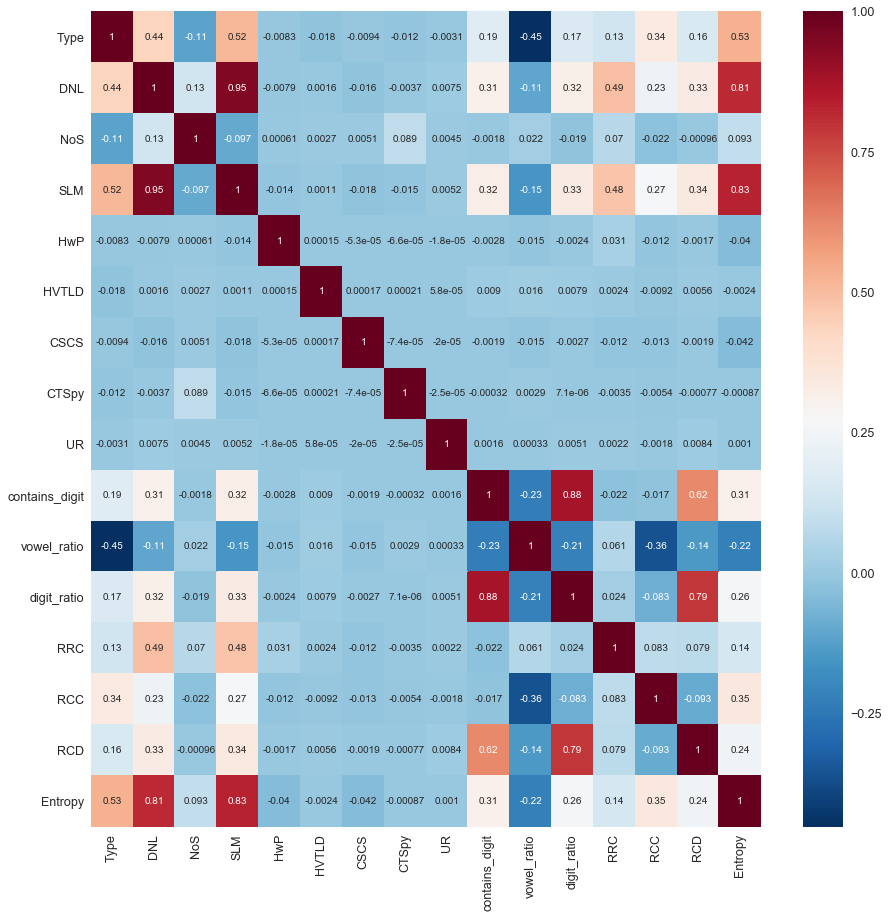

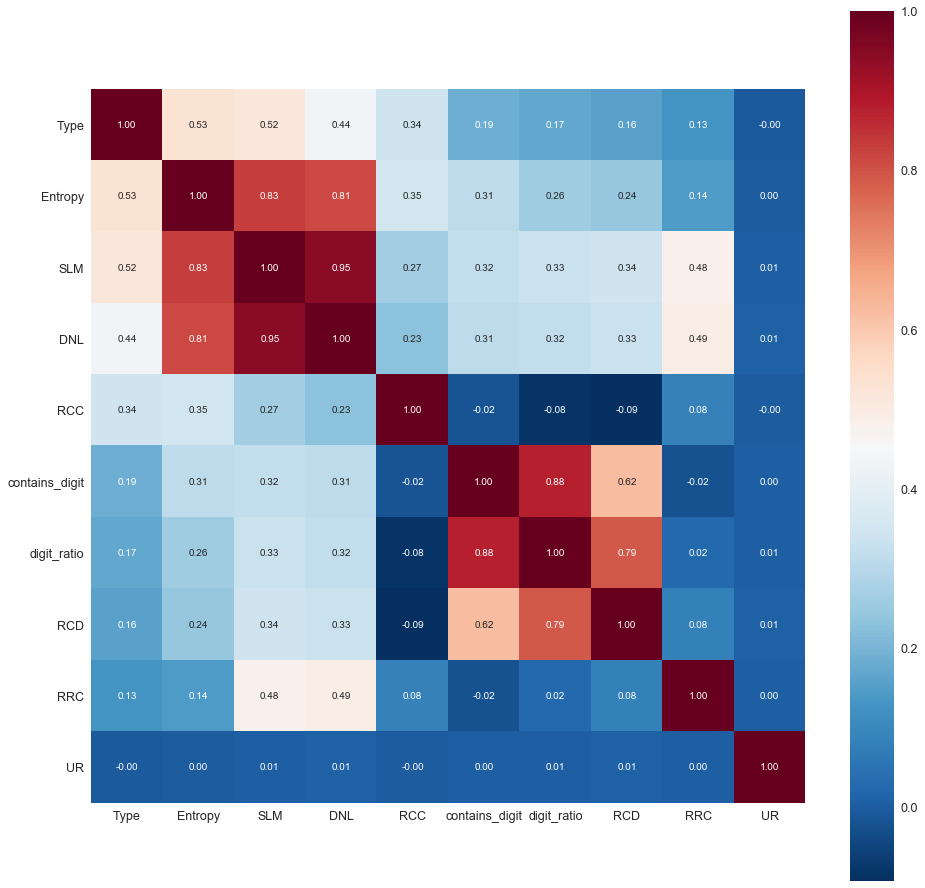

In [167]:
corrmat = domain_withFeatures.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrmat, annot=True, cmap= "RdBu_r")

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Type')['Type'].index
cm = np.corrcoef(domain_withFeatures[cols].values.T)
f, ax = plt.subplots(figsize=(16, 16))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap = "RdBu_r", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Because the attributes: `HwP`, `HVTLD`, `UR`, `CSCS` has low correlation value. So they will be **droped**. 

`DGA_Family`, `Domain` **are not necessary** for the machine learning part. Drop them also. Because they are not an appropriate input for a machine learning algorithm

In [168]:
drop_column = {'DGA_Family', 'Domain', 'HwP', 'HVTLD', 'UR', 'CSCS', 'CTSpy'}

In [169]:
# Drop the unnecessary columns
domain_withFeatures_fixed = domain_withFeatures.drop(drop_column, axis = 1)
domain_withFeatures_fixed.head()

,Type,DNL,NoS,SLM,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
0,0,8,1,5.0,0,0.400000,0.000000,0.250000,0.400000,0.000000,1.921928
1,1,22,1,18.0,0,0.333333,0.000000,0.214286,0.444444,0.000000,3.683542
2,1,19,1,16.0,0,0.250000,0.000000,0.333333,0.625000,0.000000,3.500000
3,1,22,1,18.0,1,0.076923,0.277778,0.307692,0.666667,0.111111,3.572431
4,0,18,1,14.0,1,0.307692,0.071429,0.166667,0.571429,0.000000,3.521641


In [170]:
domain_withFeatures_fixed.describe()

,Type,DNL,NoS,SLM,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
count,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06,2.475328e+06
mean,5.960131e-01,1.817001e+01,1.014754e+00,1.404965e+01,1.388826e-01,2.948431e-01,3.783541e-02,2.672135e-01,3.837673e-01,1.540836e-02,3.193887e+00
std,4.906950e-01,5.664357e+00,1.208562e-01,5.615203e+00,3.458241e-01,1.346353e-01,1.071470e-01,1.588931e-01,2.141886e-01,6.166789e-02,5.402314e-01
min,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
25%,0.000000e+00,1.400000e+01,1.000000e+00,1.000000e+01,0.000000e+00,2.000000e-01,0.000000e+00,1.578947e-01,2.500000e-01,0.000000e+00,2.905639e+00
50%,1.000000e+00,1.900000e+01,1.000000e+00,1.400000e+01,0.000000e+00,3.076923e-01,0.000000e+00,2.500000e-01,4.000000e-01,0.000000e+00,3.277613e+00
75%,1.000000e+00,2.100000e+01,1.000000e+00,1.800000e+01,0.000000e+00,3.846154e-01,0.000000e+00,3.636364e-01,5.294118e-01,0.000000e+00,3.588354e+00
max,1.000000e+00,7.300000e+01,3.000000e+00,6.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.600000e-01,9.000000e-01,4.954196e+00


In [171]:
# Checking whether there is null value
domain_withFeatures_fixed.isnull().sum()

Type              0
DNL               0
NoS               0
SLM               0
contains_digit    0
vowel_ratio       0
digit_ratio       0
RRC               0
RCC               0
RCD               0
Entropy           0
dtype: int64

**Preparing the training dataset and test dataset**

In [172]:
# Get independent variables and dependent variables
attributes = domain_withFeatures_fixed.drop('Type', axis=1)
observed = domain_withFeatures_fixed['Type']
attributes.shape, observed.shape

((2475328, 10), (2475328,))

In [173]:
# Split the dataset into training dataset and test dataset
train_X, test_X, train_y, test_y = train_test_split(attributes, observed, test_size = 0.25, random_state = RANDOM_SEED)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1856496, 10), (618832, 10), (1856496,), (618832,))

## Random Forest

In [103]:
# Set up the Random Forest Model
rf = RandomForestClassifier(random_state= RANDOM_SEED)

# Train the model with training data
rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [104]:
# Get the prediction
train_rf_pred = rf.predict(train_X)
test_rf_pred = rf.predict(test_X)

In [105]:
# Calculate the accuracy
score_rf_train = round(accuracy_score(train_y, train_rf_pred) * 100, 2)
score_rf_test = round(accuracy_score(test_y, test_rf_pred) * 100, 2)
print("Accuracy of training dataset on Random Forest Model: ", score_rf_train)
print("Accuracy of test dataset on Random Forest Model: ", score_rf_test)

Accuracy of training dataset on Random Forest Model:  92.33
Accuracy of test dataset on Random Forest Model:  91.65


## Generate the importance of each attribute

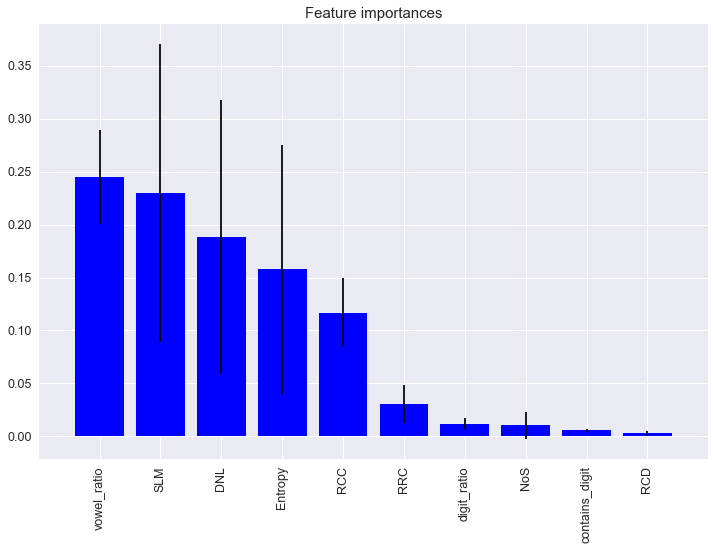

In [106]:
# Generate the importance of each attribute
X = train_X
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in indices:
    labels.append(train_X.columns[f])      
    
# Plot the feature importances of the Random Forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()


## Naive Bayes Part

In [110]:
# Use Gaussian Naive Bayse to build a model
gnb = GaussianNB()
gnb.fit(train_X, train_y)

# Get the prediction
train_gnb_pred = gnb.predict(train_X)
test_gnb_pred = gnb.predict(test_X)

In [111]:
# Caluate the accuracy
score_gnb_train = round(accuracy_score(train_y, train_gnb_pred) * 100, 2)
score_gnb_test = round(accuracy_score(test_y, test_gnb_pred) * 100, 2)
print("Accuracy of training dataset on Gaussian Naive Bayes: ", score_gnb_train)
print("Accuracy of test dataset on Gaussian Naive Bayes: ", score_gnb_test)

Accuracy of training dataset on Gaussian Naive Bayes:  80.19
Accuracy of test dataset on Gaussian Naive Bayes:  80.29


In [113]:
# Use Multinomial Naive Bayes Model
mnb = MultinomialNB(alpha=0.9)
mnb.fit(train_X, train_y)
test_mnb_pred = mnb.predict(test_X)
train_mnb_pred = mnb.predict(train_X)

In [114]:
# Calculate the accuracy
score_mnb_train = round(accuracy_score(train_y, train_mnb_pred) * 100, 2)
score_mnb_test = round(accuracy_score(test_y, test_mnb_pred) * 100, 2)
print("Accuracy of training dataset on Multinomial Naive Bayes: ", score_mnb_train)
print("Accuracy of test dataset on Multinomial Naive Bayes: ", score_mnb_test)

Accuracy of training dataset on Gaussian Naive Bayes:  75.03
Accuracy of test dataset on Gaussian Naive Bayes:  75.12


In [116]:
# Use Bernoulli Naive Bayes Model
bnb = BernoulliNB(alpha=0.9)
bnb.fit(train_X, train_y)
train_bnb_pred = bnb.predict(train_X)
test_bnb_pred = bnb.predict(test_X)

In [117]:
# Calculate the accuracy
score_bnb_train = round(accuracy_score(train_y, train_bnb_pred) * 100, 2)
score_bnb_test = round(accuracy_score(test_y, test_bnb_pred) * 100, 2)
print("Accuracy of training dataset on Gaussian Naive Bayes: ", score_bnb_train)
print("Accuracy of test dataset on Gaussian Naive Bayes: ", score_bnb_test)

Accuracy of training dataset on Gaussian Naive Bayes:  64.89
Accuracy of test dataset on Gaussian Naive Bayes:  65.01


## Logistic Regression

In [119]:
# Use Logisitic Regression to build the model
lg = LogisticRegression(random_state=RANDOM_SEED)
lg.fit(train_X, train_y)

train_lg_pred = lg.predict(train_X)
test_lg_pred = lg.predict(test_X)

In [120]:
# Calculate the accuracy
score_lg_train = round(accuracy_score(train_y, train_lg_pred) * 100, 2)
score_lg_test = round(accuracy_score(test_y, test_lg_pred) * 100, 2)
print("Accuracy of training dataset on Gaussian Naive Bayes: ", score_lg_train)
print("Accuracy of test dataset on Gaussian Naive Bayes: ", score_lg_test)

Accuracy of training dataset on Gaussian Naive Bayes:  83.59
Accuracy of test dataset on Gaussian Naive Bayes:  83.68


## Plot the auc for logistic regression

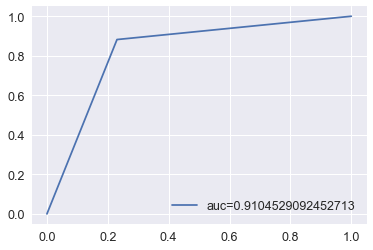

In [122]:
# Plot the AUC
labels_prediction_proba_14 = lg.predict_proba(test_X)[::,1]
fpr, tpr, _ = roc_curve(test_y, test_lg_pred)
auc = roc_auc_score(test_y, labels_prediction_proba_14)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

## H2O

In [174]:
import h2o
from h2o.automl import H2OAutoML

In [175]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,8 hours 28 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,"21 days, 10 hours and 53 minutes"
H2O cluster name:,H2O_from_python_Zlx_eo7t7t
H2O cluster total nodes:,1
H2O cluster free memory:,1.997 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [176]:
# Convert pandas.DataFrame to H2OFrame
domain_withFeatures_h2odf = h2o.H2OFrame(domain_withFeatures_fixed)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [177]:
domain_withFeatures_h2odf.describe()

Rows:2475329
Cols:11




,Type,DNL,NoS,SLM,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
type,int,int,int,real,int,real,real,real,real,real,real
mins,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.5960132976262953,18.170015379773766,1.0147535943706878,14.049652524304175,0.1388825485420322,0.29484314040262655,0.03783539505479098,0.2672135406077723,0.38376724186342304,0.015408349808884267,3.1938869392450515
maxs,1.0,73.0,3.0,63.0,1.0,1.0,1.0,1.0,0.96,0.9,4.954196310386877
sigma,0.4906949601855173,5.664357183083697,0.12085621792347623,5.615203330048672,0.3458239936253451,0.13463523049046605,0.10714699663281911,0.15889304269740553,0.21418859118489098,0.06166787998560977,0.5402314689281988
zeros,1000000,0,0,0,2131549,85974,2131557,251972,307299,2280392,513
missing,0,0,0,0,0,0,0,0,0,0,0
0,0.0,8.0,1.0,5.0,0.0,0.4,0.0,0.25,0.4,0.0,1.9219280948873625
1,1.0,22.0,1.0,18.0,0.0,0.3333333333333333,0.0,0.21428571428571427,0.4444444444444444,0.0,3.683542362433231
2,1.0,19.0,1.0,16.0,0.0,0.25,0.0,0.3333333333333333,0.625,0.0,3.5


Change the type of discerete varaible to **enum**

In [178]:
domain_withFeatures_h2odf['Type'] = domain_withFeatures_h2odf['Type'].asfactor()
# domain_withFeatures_h2odf['HwP'] = domain_withFeatures_h2odf['HwP'].asfactor()
# domain_withFeatures_h2odf['HVTLD'] = domain_withFeatures_h2odf['HVTLD'].asfactor()
# domain_withFeatures_h2odf['CSCS'] = domain_withFeatures_h2odf['CSCS'].asfactor()
# domain_withFeatures_h2odf['CTSpy'] = domain_withFeatures_h2odf['CTSpy'].asfactor()
domain_withFeatures_h2odf['contains_digit'] = domain_withFeatures_h2odf['contains_digit'].asfactor()

In [179]:
domain_withFeatures_h2odf.describe()

Rows:2475329
Cols:11




,Type,DNL,NoS,SLM,contains_digit,vowel_ratio,digit_ratio,RRC,RCC,RCD,Entropy
type,enum,int,int,real,enum,real,real,real,real,real,real
mins,,4.0,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0
mean,,18.170015379773766,1.0147535943706878,14.049652524304175,,0.29484314040262655,0.03783539505479098,0.2672135406077723,0.38376724186342304,0.015408349808884267,3.1938869392450515
maxs,,73.0,3.0,63.0,,1.0,1.0,1.0,0.96,0.9,4.954196310386877
sigma,,5.664357183083697,0.12085621792347623,5.615203330048672,,0.13463523049046605,0.10714699663281911,0.15889304269740553,0.21418859118489098,0.06166787998560977,0.5402314689281988
zeros,,0,0,0,,85974,2131557,251972,307299,2280392,513
missing,0,0,0,0,0,0,0,0,0,0,0
0,0,8.0,1.0,5.0,0,0.4,0.0,0.25,0.4,0.0,1.9219280948873625
1,1,22.0,1.0,18.0,0,0.3333333333333333,0.0,0.21428571428571427,0.4444444444444444,0.0,3.683542362433231
2,1,19.0,1.0,16.0,0,0.25,0.0,0.3333333333333333,0.625,0.0,3.5


In [85]:
# domain_withFeatures_h2odf = domain_withFeatures_h2odf.split_frame(ratios=[0.5], seed=RANDOM_SEED)[0]

In [180]:
domain_h2odf_splits = domain_withFeatures_h2odf.split_frame(ratios=[0.75], seed=RANDOM_SEED)
domain_h2o_train = domain_h2odf_splits[0]
domain_h2o_test = domain_h2odf_splits[1]

In [181]:
aml_h2o = H2OAutoML(max_runtime_secs=3600, seed=RANDOM_SEED, project_name='DGA')
aml_h2o.train(y = "Type", training_frame = domain_h2o_train, validation_frame = domain_h2o_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [182]:
aml_h2o.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20181213_180050,0.974029,0.202789,0.0872518,0.247939,0.061474
StackedEnsemble_BestOfFamily_AutoML_20181213_180050,0.973925,0.215331,0.0869145,0.251191,0.0630969
DRF_1_AutoML_20181213_113624,0.973167,0.205802,0.0878242,0.249722,0.0623611
XRT_1_AutoML_20181213_180050,0.972285,0.222562,0.0872121,0.252391,0.0637013
GBM_4_AutoML_20181213_180050,0.971904,0.212622,0.0912003,0.253394,0.0642084
GBM_3_AutoML_20181213_180050,0.968063,0.227041,0.0996403,0.262608,0.068963
GBM_2_AutoML_20181213_180050,0.965728,0.234857,0.104301,0.267685,0.0716552
GBM_1_AutoML_20181213_180050,0.963299,0.242445,0.107354,0.272651,0.0743384
GLM_grid_1_AutoML_20181213_180050_model_1,0.91011,0.389243,0.164302,0.345246,0.119195


In [183]:
h2o_drf_model = h2o.get_model("DRF_1_AutoML_20181213_180050")

In [184]:
# Save the models
model_path = h2o.save_model(model=h2o_drf_model, path="models/h2oml", force=True)

In [147]:
score_h2o_test = aml_h2o.leaderboard['auc'][0,0] * 100

In [149]:
score_h2o_test = round(score_h2o_test, 2)

---
## Neural Networks (LSTM)

### Read in all the data

In [6]:
benign_domain = pd.read_csv('./preprocessed_data/benign_domians.csv')
benign_domain.head()

,Unnamed: 0,DGA_family,Domain,Type
0,1,none,google.com,Normal
1,2,none,youtube.com,Normal
2,3,none,facebook.com,Normal
3,4,none,baidu.com,Normal
4,5,none,wikipedia.org,Normal


In [7]:
dga_domain = pd.read_csv('./preprocessed_data/360_dga_domains.csv')
dga_domain.head()

,Unnamed: 0,DGA_family,Domain,Type
0,0,nymaim,huglio.com,DGA
1,1,nymaim,hjsjsu.net,DGA
2,2,nymaim,uotgpubtuh.net,DGA
3,3,nymaim,hvtutwljc.org,DGA
4,4,nymaim,kjlunv.biz,DGA


In [8]:
bambenek_dga_domain = pd.read_csv('./preprocessed_data/bambenek_dga_domains.csv')
bambenek_dga_domain.head()

,DGA_family,Domain,Type
0,Cryptolocker,bqwqeiswupyny.com,DGA
1,Cryptolocker,oocevdwyruhdi.net,DGA
2,Cryptolocker,xhlwkqdawjdpi.biz,DGA
3,Cryptolocker,lfqkclhctolfi.ru,DGA
4,Cryptolocker,yybxvbcxxehhy.org,DGA


Now we can extract the domains from pandas DataFrame and combine two sources of DGA domains.

In [10]:
benign_domains = benign_domain['Domain'].tolist()
dga_domains = dga_domain['Domain'].tolist() + bambenek_dga_domain['Domain'].tolist()

In [11]:
len(benign_domains)

1000000

In [12]:
len(dga_domains)

2016336

We have 1 million benigh domains and 2 million DGA domains in total.

### Preprocessing

After reading in data, we need to apply some preprocessing to make our data suitable for neural networks.

First we conbine all begign and dga domains as one large list.

In [14]:
X = benign_domains + dga_domains

According to this large list which contains all the data we have, generate a dictionary of valid characters.

**Valid Characters:** Valid characters are uniques characters occurred in the data. 

By the following code, we can acquire a dictionary with valid characters in it.

In [15]:
unique_chars = enumerate(set(''.join(X))) 
chars_dict = dict()
for i, x in unique_chars: #index of enum starts with 0
    #print('i: ' + str(i) + '  x: ' + x)
    chars_dict[x] = i + 1 #leave 0 for padding

Once got the valid characters, we can calculate the max number of features for our data. This is because we use character-level embedding to represent the domian text.

In [17]:
#index 0 is also going to be a feature(padding/unknown).
max_features_num = len(chars_dict) + 1
max_features_num

40

>Note: the length of `chars_dict` is the number of valid characters, but it is not the true number of features. This is because valid characters are only features with meanings, each of them stands for a unique character. But we should know that "blank/nothing" is aslo a feature. You might be curious all our domains are consisted with characters, where does "blank" come from? The answer is "padding."

### Converting characters to sequences

Once get the `chars_dict`, we are able to convert characters to sequences. The neural networks can do nothing with characters. Either gradient descent or back propagation works with numbers. Here, the conversion can be seen as the core of data representation for deep learning in our project.

In [32]:
# Convert characters to int
X_in_int = []
for domain in X:
    domain_in_int = []
    for c in domain:
        domain_in_int.append(chars_dict[c])
    X_in_int.append(domain_in_int)

Here is the sequence of the second domains in `X`

In [33]:
X_in_int[1]

[16, 26, 13, 39, 13, 14, 34, 27, 31, 26, 17]

And this is the original text:

In [34]:
X[1]

'youtube.com'

Now, upgrade `X`

In [35]:
#update X
X = X_in_int

### Padding
Because of the requirement on input shape by neural networks which should be uniform, we need to pad all the samples(domains) to a specific length. There are two choices for us to pad:
1. Choose a length that covers most of samples.
2. Choose a length that covers all the samples.

#### Pros and cons rise accordingly.
For the first one, imagine a situation in which the lengths of data is unbalanced distributed. Most of the data have moderate lengths,and only a small part has long lengths. If we plot this distribution out, it will look like a lognormal distribution.

C:\Users\Sean\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


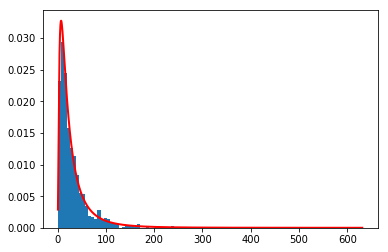

In [19]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
      / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

In this case, when we choose a length not intending to cover all the lengths, the padding length can be much smaller than choosing the max length which covers all the data lengths. Because this padding lenght can cover most of our data, we can still represent the data well without loosing too much information(only those extra-long data would be cut-off), which means, by choosing this length, we can avoid bias(unavoidable) to the model to be trained. Meanwhile, a smaller length would save us a lot of computing resources.

Now, let's see the max length of domains in our data.

In [36]:
#max length will be the max length of domain in our dataset
maxlen = np.max([len(x) for x in X])

In [37]:
maxlen

73

The max length is 73 which is not a big number for our model. Thus we decided to set 73 as the padding length.

Then pad `X`

In [38]:
#pad to max length
X = sequence.pad_sequences(X, maxlen=maxlen)

In [39]:
X.shape

(3016336, 73)

### Generating Y

Currently, the `X` is a simple ordered combination of benign and DGA domains. It is easy to genrate Y based on the population of each type of domains. 

In [40]:
#Generate corresponding Y, 0 for 'benign'; 1 for 'dga'
Y = np.hstack([np.zeros(len(benign_domains)),np.ones(len(dga_domains))])

## LSTM
Long short-term memory (LSTM) neural network is a special recurrent neural network composed of LSTM units. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on sequences data, it can learn from context.

In our project, we were thinking LSTM should be a good shot compaered with CNN. Now let's see how do we train an LSTM neural network for classifying benign and DGA domains.


### Build LSTM model

This is a quite simple LSTM model, only one LSTM layer with 64 LSTM units. In our experiments, we found simple LSTM is able to work well! Thus we decided to keep it simple.

- **loss function:** binary_crossentropy
- **optimizer:** rmsprop
- **metrics:** accuracy

>Note: When building an RNN(LSTM is one of it), it is recommended by Dr. Geoffrey Hinton at [here](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) to use RMSProp to optimize. 

In [21]:
def build_model(max_features_num, maxlen):
    """Build LSTM model"""
    model = Sequential()
    model.add(Embedding(max_features_num, 64, input_length=maxlen))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['binary_crossentropy','acc'])

    return model

### Train the model

As a concern of the data size, we decided to resample to get a smaller set for training.

Because of the size of benigns domains is 1M, the cut point will be the index of the last benigns domain, which will be:

In [41]:
pos_neg_cutpoint = len(benign_domains)
print("The cut point will be "+ str(pos_neg_cutpoint))

The cut point will be 1000000


Now, randomly select the same amount of domains from both benigns and dgas.

In [42]:
#set new sampling szie as 300K
sampling_size = 150000

pos_indices = random.sample(range(pos_neg_cutpoint),sampling_size)
neg_indices = random.sample(range(pos_neg_cutpoint, len(X)),sampling_size)

In [43]:
len(pos_indices)

150000

In [44]:
pos_indices[:10]

[16447, 750929, 441575, 811478, 258420, 997863, 914520, 291608, 22078, 506997]

In [45]:
len(neg_indices)

150000

In [46]:
neg_indices[:10]

[2187333,
 1443096,
 1821710,
 2453743,
 1687413,
 2723395,
 1897780,
 1473121,
 2899359,
 1788546]

In [47]:
new_X = X[pos_indices + neg_indices]
new_Y = Y[pos_indices + neg_indices]

In [48]:
new_X.shape

(300000, 73)

#### Fit the model

Here is an example of a typical experiment.

In [0]:
#training parameters

max_epoch=25
nfolds=10
batch_size=128

In [0]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss', 
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=5, #number of epochs with no improvement after which training will be stopped
                        verbose=0, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=False))

In [120]:
model = build_model(max_features_num, maxlen)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 73, 64)            2560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 35,649
Trainable params: 35,649
Non-trainable params: 0
_________________________________________________________________


In [121]:
history = model.fit(x=new_X, y=new_Y, 
                    batch_size=batch_size, 
                    epochs=max_epoch, 
                    verbose=1, 
                    callbacks=cb, 
                    validation_split=0.2, #
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0,
                    steps_per_epoch=None, 
                    validation_steps=None)

Train on 240000 samples, validate on 60000 samples
Epoch 1/25
240000/240000 [==============================] - 399s 2ms/step - loss: 0.2053 - binary_crossentropy: 0.2053 - acc: 0.9207 - val_loss: 0.1693 - val_binary_crossentropy: 0.1693 - val_acc: 0.9317
Epoch 2/25
240000/240000 [==============================] - 396s 2ms/step - loss: 0.1028 - binary_crossentropy: 0.1028 - acc: 0.9649 - val_loss: 0.1035 - val_binary_crossentropy: 0.1035 - val_acc: 0.9622
Epoch 3/25
240000/240000 [==============================] - 398s 2ms/step - loss: 0.0681 - binary_crossentropy: 0.0681 - acc: 0.9773 - val_loss: 0.0968 - val_binary_crossentropy: 0.0968 - val_acc: 0.9663
Epoch 4/25
240000/240000 [==============================] - 396s 2ms/step - loss: 0.0530 - binary_crossentropy: 0.0530 - acc: 0.9827 - val_loss: 0.0859 - val_binary_crossentropy: 0.0859 - val_acc: 0.9698
Epoch 5/25
240000/240000 [==============================] - 393s 2ms/step - loss: 0.0463 - binary_crossentropy: 0.0463 - acc: 0.9847 

In [0]:
model.save('LSTM_on_300K')

#### Plot training & validation accuracy values 

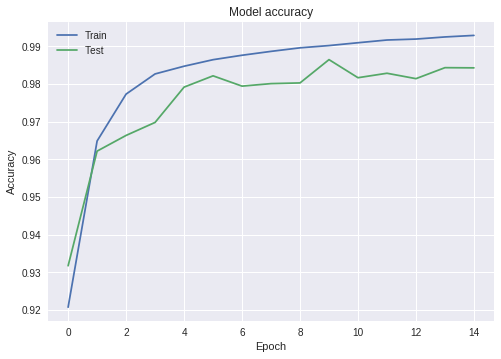

In [124]:
# Plot training & validation accuracy values 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show() 

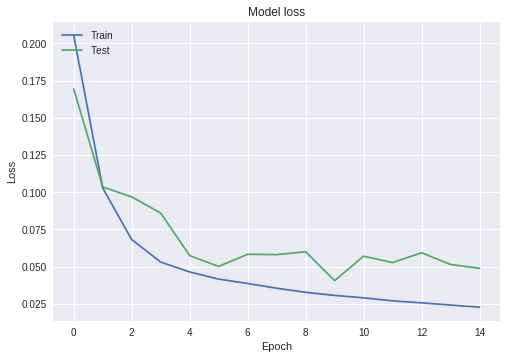

In [125]:

# Plot training & validation loss values 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## CNN

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex.

Typically, CNN is used on image/audio data. It plays a vital role in cognitive computing like image/voice recognition. But there are some approaches to text classification that use CNN as the classifier.

Now let's see how do we train a CNN model for classifying benign and DGA domains.

First, in our experiments, we found that CNN models overfit easily. There are three main methods to reduce overfitting:
1. Using dropout layer
2. Adding regularizers
3. Providing more data

This is hwo to define an l2 regularizer with keras:

In [52]:
rglrzr = regularizers.l2(0.01)

### Build a model

We used 1D convolution layer because the input shape is `(maxlen, 1)` and the logic to analyize a give domain is by its context. This is a horizontal logic.

In [53]:
def build_model(max_features_num, maxlen):
    """Build CNN model"""
    model = Sequential()
    model.add(Conv1D(32, 3, strides=1, 
                     input_shape=(maxlen,1),
                     padding='valid', 
                     data_format='channels_last', 
                     dilation_rate=1, 
                     activation='relu', 
                     use_bias=True, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='zeros', 
                     kernel_regularizer=rglrzr, 
                     bias_regularizer=None, 
                     activity_regularizer=None, 
                     kernel_constraint=None, 
                     bias_constraint=None))
    model.add(MaxPooling1D(pool_size=2, 
                           strides=None, 
                           padding='valid', 
                           data_format='channels_last'))
    model.add(Dropout(0.3))
    '''
    model.add(Conv1D(32, 3, strides=1, 
                       padding='valid', 
                       data_format='channels_last', 
                       dilation_rate=1, 
                       activation='relu', 
                       use_bias=True, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='zeros', 
                       kernel_regularizer=None, 
                       bias_regularizer=None, 
                       activity_regularizer=None, 
                       kernel_constraint=None, 
                       bias_constraint=None))
      model.add(MaxPooling1D(pool_size=2, 
                             strides=None, 
                             padding='valid', 
                             data_format='channels_last'))
      model.add(Dropout(0.3))
      '''
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_crossentropy','acc'])

    return model

#### Fit the model

In [54]:
#training parameters

max_epoch=25
nfolds=10
batch_size=128

In [55]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss', 
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=5, #number of epochs with no improvement after which training will be stopped
                        verbose=0, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=False))

In [58]:
model = build_model(max_features_num, maxlen)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 71, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1120)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1121      
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Currently, the shape of our input data `new_x` is (None, 73) which is not meet the expected shape of CNN model. 

Thus before training, we shall reshape the data to (None, 73, 1).

In [60]:
newnew_x = np.reshape(new_X,(new_X.shape[0],new_X.shape[1],1))

In [61]:
newnew_x.shape

(300000, 73, 1)

In [ ]:
history = model.fit(x=newnew_x, y=new_Y, 
                    batch_size=batch_size, 
                    epochs=max_epoch, 
                    verbose=1, 
                    callbacks=cb, 
                    validation_split=0.2, #
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0,
                    steps_per_epoch=None, 
                    validation_steps=None)

The this part of code is copy from another notebook of an experiment. Thus the training progress is not available.

In [ ]:
model.save('CNN_on_300K')

CNN models didn't perform well on out task. 

Here are training accuracy and loss curves in one of experiments.

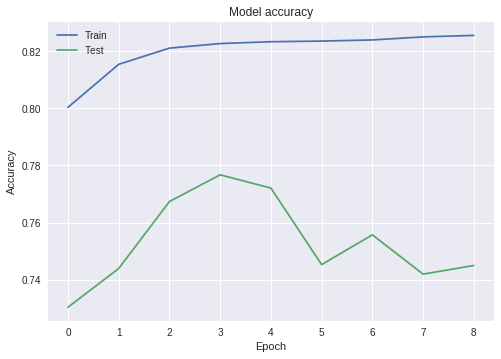

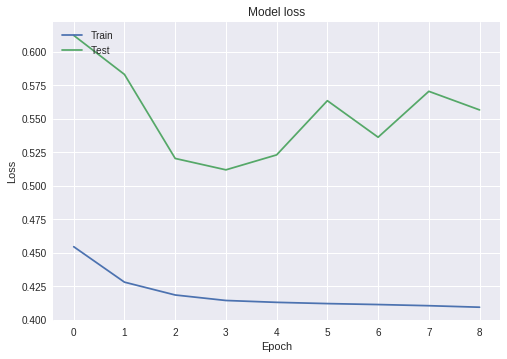

In [153]:
score_lstm_test = lstm_model.score(test_X, test_y) * 100

## Sum up

In [98]:
# All model accuracy data (2014)
model_Score = {
    'Bernoulli Naive Bayes':score_bnb_test,
    'Gaussian Naive Bayes':score_gnb_test,
    'Logistic Regression':score_lg_test,
    'Multinomial Naive Bayes Model':score_mnb_test,
    'Random Forest':score_rf_test,
    'H2O':score_h2o_test,
    'LSTM NN': score_lstm_test
}

In [99]:
model_Score

{'Bernoulli Naive Bayes': 65.02,
 'Gaussian Naive Bayes': 72.56,
 'Logistic Regression': 83.65,
 'Multinomial Naive Bayes Model': 75.11,
 'Random Forest': 91.65,
 'H2O': 97.34,
 'LSTM NN': 98.56}

In [100]:
# Plot each model score
def showScore(model_score_dict, title):
    score = pd.Series(model_score_dict)
    score = score.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = score.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([60.0, 100.0])
    plt.xlabel('Model')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.show()

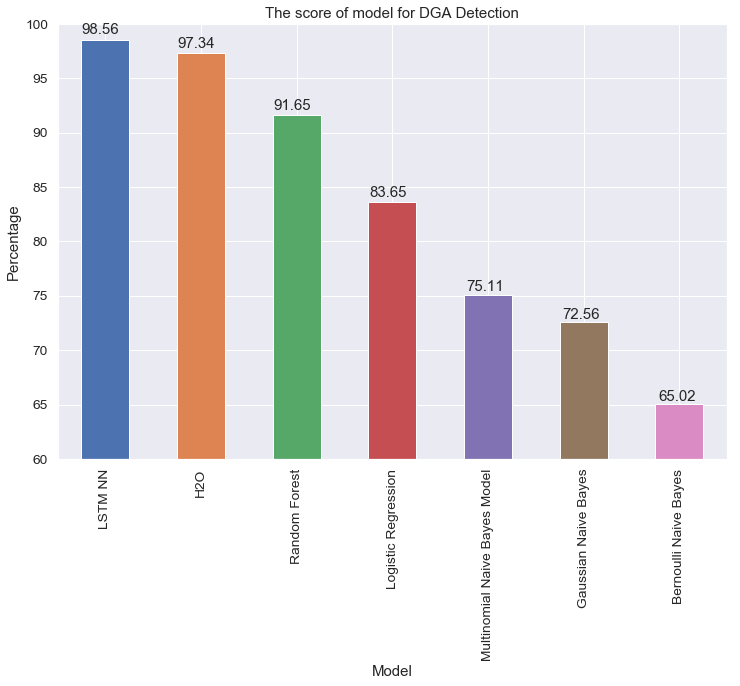

In [101]:
showScore(model_Score, 'The score of model for DGA Detection')